In [1]:
!pip install transformers

     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 3.2MB 52.2MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9735d9565da497ca442be49ec35cb056e7c8ea3f708173cd23955a0e603229d5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive

current_directory = '/content/drive/My Drive/FSem/'
drive.mount('/content/drive')

Mounted at /content/drive


# Headers and Global Variables

In [3]:
import csv
import torch
from torch.nn.functional import softmax
from transformers import BertForNextSentencePrediction, BertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from matplotlib import pyplot as plt


device = "cuda:0" if torch.cuda.is_available() else "cpu"

CLOZE_MODEL = 'bertfornsp_cloze_finetuned'
ROC_MODEL = 'bertfornsp_roc_finetuned'
# underlying pretrained LM
BASE_MODEL = 'bert-large-uncased-whole-word-masking'

BATCH_SIZE = 12
WARMUP_EPOCHS = 1
TRAIN_EPOCHS = 10
LAST_EPOCH = -1

# Datasets

In [4]:
class RocStories(torch.utils.data.Dataset):
    def __init__(self):    
        dataset = []       
        with open(current_directory + 'roc_stories.csv', 
                  'r', encoding='utf-8') as d:
            
            reader = csv.reader(d, quotechar='"', delimiter=',',
                                quoting=csv.QUOTE_ALL, skipinitialspace=True)                
            for line in reader:
                dataset.append(line)  

        self.data = []
        self.labels = []

        stories = []
        endings = []
        for sample in dataset:           
            start = " ".join(sample[2:-1])
            stories.append(start)            
            end = sample[-1]                        
            endings.append(end)

        from random import shuffle
        wrong_endings = endings.copy()
        shuffle(wrong_endings)

        assert len(stories) == len(endings)
        for i, story in enumerate(stories):
            
            #True Ending
            self.data.append([story, endings[i]])
            self.labels.append(0)

            #Wrong Ending
            self.data.append([story, wrong_endings[i]])
            self.labels.append(1)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]        
        return X, y

    def __len__(self):
        assert len(self.data) == len(self.labels)
        return len(self.labels)

In [5]:
class ClozeTest(torch.utils.data.Dataset):
    def __init__(self, dev=True):
        
        dataset = []

        # if dev=True, we load the dev set for testing
        with open(current_directory + 'cloze_test.csv' if dev else 
                  current_directory + 'cloze_train.csv', 
                  'r', encoding='utf-8') as d:
            reader = csv.reader(d, quotechar='"', delimiter=',', 
                                quoting=csv.QUOTE_ALL, skipinitialspace=True)                
            for line in reader:
                dataset.append(line) 

        self.data = []
        self.labels = []

        for sample in dataset:
            
            start = " ".join(sample[1:-3])
            end1 = sample[-3]
            end2 = sample[-2]
            right_ending = sample[-1]

            self.data.append([start, end1])
            self.labels.append(0 if "1" == right_ending else 1)

            self.data.append([start, end2])
            self.labels.append(0 if "2" == right_ending else 1)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]        
        return X, y

    def __len__(self):
        assert len(self.data) == len(self.labels)
        return len(self.labels)

# Auxiliary Functions

In [6]:
def getModelFileName(model_name, last_epoch):
    return current_directory + model_name + str(last_epoch)

In [7]:
def getLossesFileName(model_name, epoch):
    return current_directory + model_name + str(epoch) + "losses.txt"

In [8]:
def getOptimizerFileName(model_name, last_epoch):
    return current_directory + model_name + str(last_epoch) + "optimizer.pt"

In [9]:
def weight_diff(model1, model2):
    model1, model2 = model1.to("cpu"), model2.to("cpu")
    diff = torch.nn.MSELoss() # diff(a, b) = ((a - b) ** 2).mean()

    xweights, yweights, xbiases, ybiases = dict(), dict(), dict(), dict()
    layer_names = set()

    for (name, parameter1), parameter2 in zip(
        model1.bert.encoder.layer.named_parameters(),
        model2.bert.encoder.layer.parameters()
    ):

        difference = diff(parameter1, parameter2).item()

        name = name.split(".")
        xtick = float(name[0])
        layer_name = ".".join(name[1:-1])
        parameter_type = name[-1]

        if layer_name not in layer_names:
            layer_names.add(layer_name)
            xweights[layer_name], xbiases[layer_name] = list(), list()
            yweights[layer_name], ybiases[layer_name] = list(), list()

        if parameter_type == "weight":
            yweights[layer_name].append(difference)
            xweights[layer_name].append(xtick + 0.0)
        else: # if parameter_type == "bias"
            ybiases[layer_name].append(difference)
            xbiases[layer_name].append(xtick + 0.5)

    for name in layer_names:
        plt.bar(xweights[name], yweights[name], width=0.4, label="weight")
        plt.bar(xbiases[name], ybiases[name], width=0.4, label="bias")
        plt.xticks(xweights[name])
        plt.legend()
        plt.title(name)
        plt.show()

# Functions for Training and Testing

In [10]:
def train(model_file=BASE_MODEL, batch_size=BATCH_SIZE,
          warmup_epochs=WARMUP_EPOCHS, train_epochs=TRAIN_EPOCHS,
          last_epoch=LAST_EPOCH, cloze_test=True, verbose=False):
    
    tokenizer = BertTokenizer.from_pretrained(BASE_MODEL)
    model = BertForNextSentencePrediction.from_pretrained(model_file)
    # The old weights are saved in model_old to be used to compare to model
    model_old = BertForNextSentencePrediction.from_pretrained(model_file)

    #Send to GPU and allow Training
    model = model.to(device)
    model.train()

    trainloader = torch.utils.data.DataLoader(
        ClozeTest(dev=False) if cloze_test else RocStories(),
        batch_size=batch_size, shuffle=True
    )

    #LR maybe needs to be optimized
    optimizer = AdamW(model.parameters(), lr=1e-5)
    if last_epoch != -1:
        optimizer.load_state_dict(
            torch.load(getOptimizerFileName(model_file, last_epoch))
        )
    n_batches =  len(trainloader)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=(warmup_epochs * n_batches),
        num_training_steps=(train_epochs * n_batches),
        last_epoch=(last_epoch + 1) * n_batches - 1 # actually, last_step
    )

    epochs_range = range(last_epoch + 1, train_epochs)
    for epoch in epochs_range:
        losses = []
        
        for batchId, (stories, labels) in tqdm(zip(range(n_batches), trainloader)):
            # this is PyTorch-specific as gradients get accumulated        
            optimizer.zero_grad()

            start = stories[0]
            end = stories[1]

            labels = labels.to(device)
           
            # Tokenize sentence pairs.
            # All sequences in batch processing must be same length.
            # Therefore we use padding to fill shorter sequences
            # with uninterpreted [PAD] tokens)
            tokenized_batch = tokenizer(start, padding = True, text_pair = end,
                                        return_tensors='pt').to(device)
            
            loss = model(**tokenized_batch, labels = labels).loss
            if verbose:
                print("Epoch " + str(epoch + 1) + 
                      " Batch " + batchId + " of " + n_batches + 
                      " Loss: " + loss.item())
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step() # Huggingface specific: step = epoch

        # Save model parameters in a file after the epoch
        model.save_pretrained(getModelFileName((CLOZE_MODEL if cloze_test
                                                else ROC_MODEL), epoch + 1))
        # Save optimizer state after the epoch
        torch.save(optimizer.state_dict(),
                   getOptimizerFileName((CLOZE_MODEL if cloze_test
                                         else ROC_MODEL), epoch + 1))
        # Save the losses during the epoch
        with open(getLossesFileName((CLOZE_MODEL if cloze_test  else ROC_MODEL),
                                   epoch), 'w') as f:
            f.write("\n".join([str(loss) for loss in losses]))
    
    # Losses are gathered for plotting
    losses = []
    for epoch in range(train_epochs):
        with open(getLossesFileName((CLOZE_MODEL if cloze_test  else ROC_MODEL),
                                   epoch), 'r') as f:
            for line in f:
                losses.append(float(line))
    # Loss function change over steps is plotted below.
    plt.plot(losses)
    plt.xticks(
        ticks=[i * n_batches for i in epochs_range],
        labels=epochs_range
    )
    plt.title(("Story Cloze" if cloze_test else "ROCStories") + " Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Models are compared
    weight_diff(model, model_old)

In [11]:
def test(model_file=BASE_MODEL, verbose = False):
    softmax = torch.nn.Softmax(dim=1)
    tokenizer = BertTokenizer.from_pretrained(BASE_MODEL)
    model = BertForNextSentencePrediction.from_pretrained(model_file)

    #Send to GPU and allow Evaluation
    model = model.to(device)
    model.eval()

    #Dataloader
    devloader = torch.utils.data.DataLoader(ClozeTest(), batch_size=10)

    pred_list, label_list = list(), list()

    for stories, labels in tqdm(devloader, disable=verbose):
        
        start = stories[0]
        end = stories[1]
        
        # Tokenize sentence pairs.
        # All sequences in batch processing must be same length.
        # Therefore we use padding to fill shorter sequences
        # with uninterpreted [PAD] tokens)
        tokenized_batch = tokenizer(start, padding = True, text_pair = end,
                                    return_tensors='pt').to(device)

        #Send to GPU
        labels = labels.to(device)

        outputs = model(**tokenized_batch, labels = labels)
        logits = outputs.logits

        # Model predicts sentence-pair as correct if True-logit > False-logit
        predictions = logits.argmax(dim=1).int()
        probs = softmax(logits).cpu().detach()

        # Extra info print() if verbose
        if verbose:
            # iterate over elements in batch
            for i, element_input_ids in enumerate(tokenized_batch.input_ids):
                print(tokenizer.decode(element_input_ids))
                print("Probability:", probs[i][0].item() * 100)
                print("Predicted: ", bool(predictions[i]))
                print("True label: ", bool(labels[i]))

        pred_list.extend(predictions.tolist())
        label_list.extend(labels.tolist())

    print(confusion_matrix(label_list, pred_list))
    print(classification_report(label_list, pred_list))

# Testing Pretrained BertForNextSentencePrediction

In [12]:
test()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 375/375 [00:49<00:00,  7.56it/s]


[[ 348 1523]
 [ 298 1575]]
              precision    recall  f1-score   support

           0       0.54      0.19      0.28      1871
           1       0.51      0.84      0.63      1873

    accuracy                           0.51      3744
   macro avg       0.52      0.51      0.46      3744
weighted avg       0.52      0.51      0.46      3744



# Training and Testing the Model on ROCStories Dataset

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForNextSentencePredic

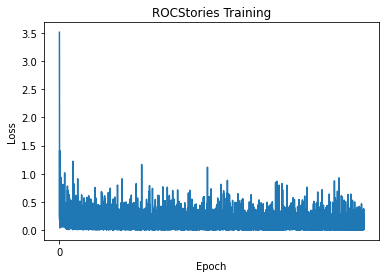

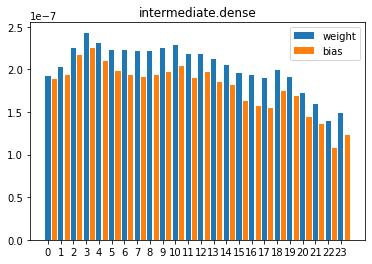

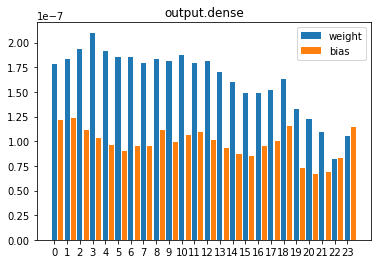

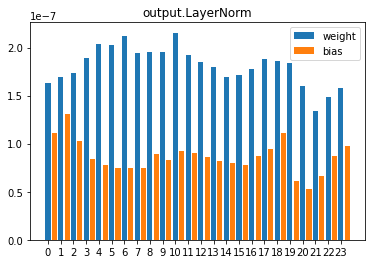

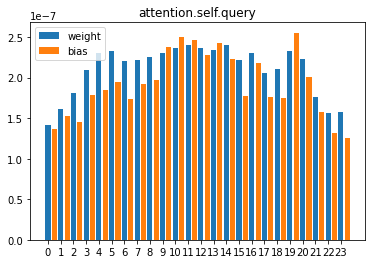

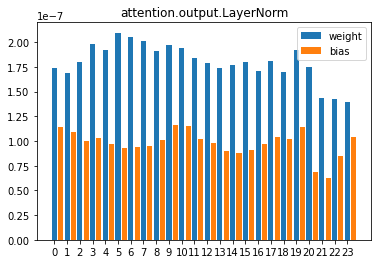

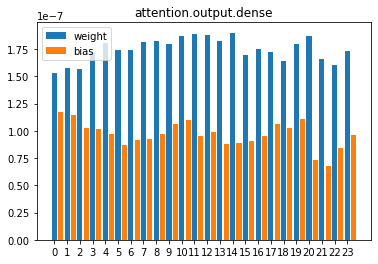

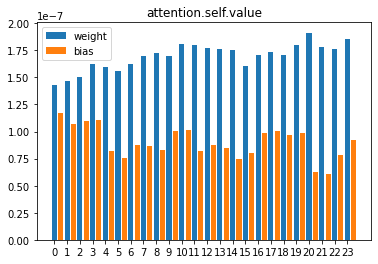

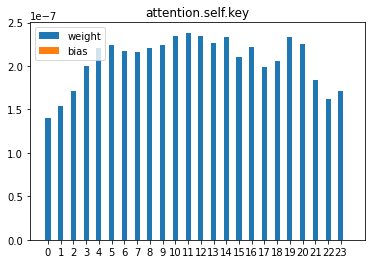

100%|██████████| 375/375 [00:54<00:00,  6.92it/s]

[[1838   33]
 [1710  163]]
              precision    recall  f1-score   support

           0       0.52      0.98      0.68      1871
           1       0.83      0.09      0.16      1873

    accuracy                           0.53      3744
   macro avg       0.67      0.53      0.42      3744
weighted avg       0.67      0.53      0.42      3744



In [13]:
train_epochs_roc = 1
train(train_epochs=train_epochs_roc, warmup_epochs=0, cloze_test=False)
test(getModelFileName(ROC_MODEL, train_epochs_roc))

# Training and Testing the Model Further on StoryCloze Dataset

262it [02:42,  1.62it/s]
262it [02:41,  1.62it/s]
262it [02:42,  1.62it/s]
262it [02:41,  1.62it/s]
262it [02:42,  1.62it/s]
262it [02:43,  1.61it/s]
262it [02:43,  1.61it/s]
262it [02:42,  1.61it/s]
262it [02:42,  1.61it/s]
262it [02:42,  1.62it/s]


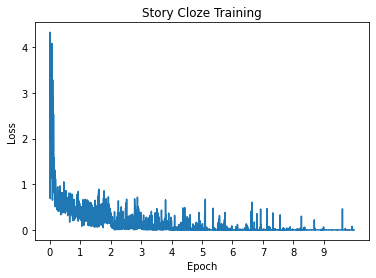

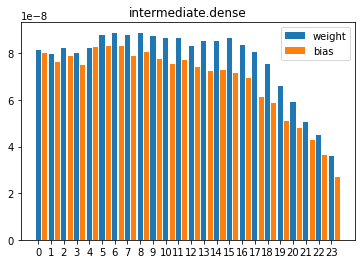

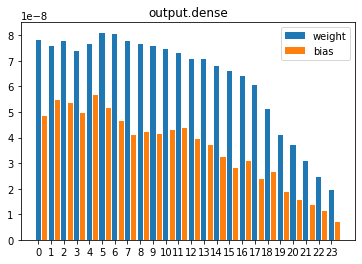

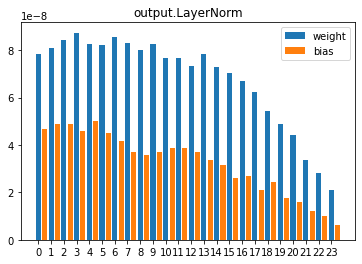

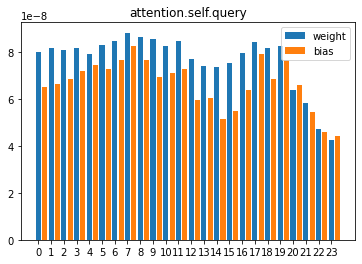

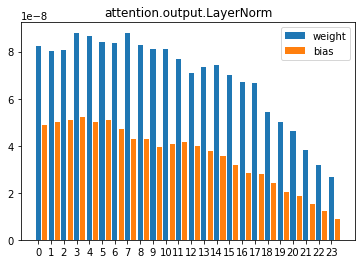

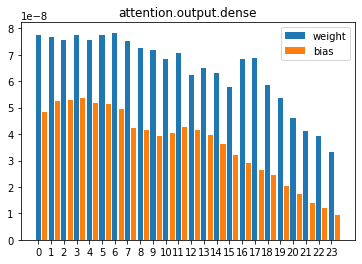

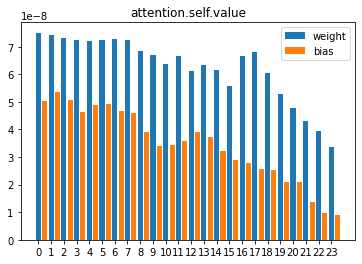

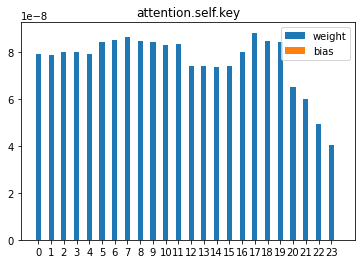

100%|██████████| 375/375 [00:53<00:00,  7.02it/s]

[[1656  215]
 [ 312 1561]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1871
           1       0.88      0.83      0.86      1873

    accuracy                           0.86      3744
   macro avg       0.86      0.86      0.86      3744
weighted avg       0.86      0.86      0.86      3744



In [14]:
train_epochs_cloze = 10
train(model_file=getModelFileName(ROC_MODEL, train_epochs_roc), cloze_test=True)
test(getModelFileName(CLOZE_MODEL, train_epochs_cloze))